Привет, меня зовут Артем Хуршудов. Сегодня я проверю твой проект.
<br> Дальнейшее общение будет происходить на "ты" если это не вызывает никаких проблем.
<br> Желательно реагировать на каждый мой комментарий ('исправил', 'не понятно как исправить ошибку', ...)
<br> Пожалуйста, не удаляй комментарии ревьюера, так как они повышают качество повторного ревью.

Комментарии будут в <font color='green'>зеленой</font>, <font color='blue'>синей</font> или <font color='red'>красной</font> рамках:

<div class="alert alert-block alert-success">
<b>Успех:</b> Если все сделано отлично
</div>

<div class="alert alert-block alert-info">
<b>Совет: </b> Если можно немного улучшить
</div>

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Если требуются исправления. Работа не может быть принята с красными комментариями.
</div>

-------------------

Будет очень хорошо, если ты будешь помечать свои действия следующим образом:
<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> ...
</div>

<div class="alert alert-block alert-warning">
<b>Изменения:</b> Были внесены следующие изменения ...
</div>

### <font color='orange'>Общее впечатление</font>
* Большое спасибо за проделанную работу. Видно, что приложено много усилий.
* Радует, что ноутбук хорошо структурирован. Приятно проверять такие работы.
* Отлично, что тебе удалось освоить внутренний метод кодировки признаков.
* Над этим проектом нужно будет еще немного поработать. Однако, изменения не должны занять много времени.
* В работе я оставил несколько советов. Буду рад, если ты учтешь их.
* С радостью отвечу на твои вопросы, если они есть. Лучше всего их собрать в следующей ячейке. Жду новую версию проекта.

### <font color='orange'>Общее впечатление (ревью 2)</font>
* После исправлений проект улучшился и теперь он может быть зачтен.
* Для удобства все новые комментарии обозначены фразой "ревью 2".
* Удачи в дальнейшем обучении и следующих работах!

# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Признаки

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак

- Price — цена (евро)

In [43]:
pip install catboost

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [44]:
pip install shap

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [83]:
import pandas as pd
import numpy as np
import shap

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_squared_error

import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично, что все импорты собраны в первой ячейке ноутбука! Если у того, кто будет запускать твой ноутбук будут отсутствовать некоторые библиотеки, то он это увидит сразу, а не в процессе!
</div>

## Подготовка данных

Для отображения таблицы полностью добавим атрибуты

In [46]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [47]:
def missing_zero_values_table(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
        return mz_table

In [48]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

In [49]:
print(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB
None


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [50]:
col = str(df.columns).lower
col()

"index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox', 'power', 'model', 'kilometer', 'registrationmonth', 'fueltype', 'brand', 'notrepaired', 'datecreated', 'numberofpictures', 'postalcode', 'lastseen'], dtype='object')"

In [51]:
df.columns = ['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox', 'power', 'model', 'kilometer', 'registration_month', 'fuel_type', 'brand', 'not_repaired', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen']

In [52]:
df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [53]:
df.date_crawled = df.date_crawled.astype('datetime64')
df.date_created = df.date_created.astype('datetime64')
df.last_seen = df.last_seen.astype('datetime64')

In [54]:
missing_zero_values_table(df)

Your selected dataframe has 16 columns and 354369 Rows.
There are 5 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
not_repaired,0,71154,20.1,71154,20.1,object
vehicle_type,0,37490,10.6,37490,10.6,object
fuel_type,0,32895,9.3,32895,9.3,object
gearbox,0,19833,5.6,19833,5.6,object
model,0,19705,5.6,19705,5.6,object


<div class="alert alert-block alert-success">
<b>Успех:</b> Данные загружены корректно, первичный осмотр проведен.
</div>

Рассмотрим каждый признак с пропущенными значениями в отдельности

In [55]:
df.not_repaired.value_counts()

no     247161
yes     36054
Name: not_repaired, dtype: int64

Пропущенные данные о ремонте обозначим как "no"

In [56]:
df.not_repaired = df.not_repaired.fillna('no')
df.not_repaired.value_counts()

no     318315
yes     36054
Name: not_repaired, dtype: int64

In [57]:
df.vehicle_type.value_counts()

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: vehicle_type, dtype: int64

Пропущенные данные о типе ТС обозначим как "other"

In [58]:
df.vehicle_type = df.vehicle_type.fillna('other')
df.vehicle_type.value_counts()

sedan          91457
small          79831
wagon          65166
other          40778
bus            28775
convertible    20203
coupe          16163
suv            11996
Name: vehicle_type, dtype: int64

In [59]:
df.fuel_type.value_counts()

petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64

Пропущенные данные о типе топлива обозначим как "petrol"

In [60]:
df.fuel_type = df.fuel_type.fillna('petrol')
df.fuel_type.value_counts()

petrol      249247
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64

In [61]:
df.gearbox.value_counts()

manual    268251
auto       66285
Name: gearbox, dtype: int64

In [62]:
df.gearbox = df.gearbox.fillna('manual')
df.gearbox.value_counts()

manual    288084
auto       66285
Name: gearbox, dtype: int64

In [63]:
df.model.value_counts()

golf                  29232
other                 24421
3er                   19761
polo                  13066
corsa                 12570
astra                 10809
passat                10146
a4                     9900
c_klasse               8312
5er                    7868
e_klasse               6785
a3                     6122
focus                  5874
fiesta                 5774
a6                     5541
twingo                 4953
transporter            4822
2_reihe                4816
fortwo                 4337
vectra                 4254
a_klasse               4193
mondeo                 3601
clio                   3546
1er                    3514
3_reihe                3493
touran                 3470
punto                  3347
zafira                 3044
megane                 2910
ibiza                  2702
ka                     2702
lupo                   2594
octavia                2108
fabia                  2080
cooper                 1950
clk                 

In [64]:
df.model = df.model.fillna('other')
df.model.value_counts()

other                 44126
golf                  29232
3er                   19761
polo                  13066
corsa                 12570
astra                 10809
passat                10146
a4                     9900
c_klasse               8312
5er                    7868
e_klasse               6785
a3                     6122
focus                  5874
fiesta                 5774
a6                     5541
twingo                 4953
transporter            4822
2_reihe                4816
fortwo                 4337
vectra                 4254
a_klasse               4193
mondeo                 3601
clio                   3546
1er                    3514
3_reihe                3493
touran                 3470
punto                  3347
zafira                 3044
megane                 2910
ibiza                  2702
ka                     2702
lupo                   2594
octavia                2108
fabia                  2080
cooper                 1950
clk                 

In [65]:
df.model.nunique()

250

In [66]:
df.isnull().sum()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
not_repaired          0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64

In [67]:
df = df.dropna()

In [68]:
df.isnull().sum()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
not_repaired          0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64

<div class="alert alert-block alert-success">
<b>Успех:</b> Обработать прпоуски таким образом – хорошее решение!
</div>

Проверим количество объектов с отсутствующей ценой

In [69]:
df[df['price']==0].count() / df.shape[0] * 100

date_crawled          3.039769
price                 3.039769
vehicle_type          3.039769
registration_year     3.039769
gearbox               3.039769
power                 3.039769
model                 3.039769
kilometer             3.039769
registration_month    3.039769
fuel_type             3.039769
brand                 3.039769
not_repaired          3.039769
date_created          3.039769
number_of_pictures    3.039769
postal_code           3.039769
last_seen             3.039769
dtype: float64

Удалим эти данные

In [70]:
df = df[df['price']!=0]

Вывод: загрузили данные, заменили пропуски

<div class="alert alert-block alert-success">
<b>Успех:</b> Хорошо, что аномалии в стоимости были удалены.
</div>

## Обучение моделей

Подготовим данные, разделим выборку на обучающую и валидационную, выделим признаки и целевой признак

In [71]:
df_clear = df.drop(['date_crawled', 'date_created', 'last_seen'], axis=1)  
df_ohe = pd.get_dummies(df_clear, drop_first=True)
features_train, features_valid, target_train, target_valid = train_test_split(
    df_ohe.drop(['price'], axis=1), df_ohe.price, test_size=0.2, random_state=12345)

<div class="alert alert-block alert-success">
<b>Успех:</b> Разбиение было сделано верно.
</div>

<div class="alert alert-block alert-info">
<b>Совет: </b> Выборки лучше было бы назвать train и test.
</div>

### LinearRegression

In [72]:
%%time
1 + 1
model = LinearRegression()
model.fit(features_train, target_train)

CPU times: user 24.7 s, sys: 8.87 s, total: 33.5 s
Wall time: 36 s


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [73]:
predictions_train = model.predict(features_train) #предсказания на обучающей выборке
predictions_valid = model.predict(features_valid) #предсказания на валидационной выборке
print("RMSE на обучающей выборке: ", round(mean_squared_error(target_train, predictions_train) ** 0.5, 2)) 
print("RMSE на валидационной выборке: ", round(mean_squared_error(target_valid, predictions_valid) ** 0.5, 2))

RMSE на обучающей выборке:  3160.52
RMSE на валидационной выборке:  3165.52


Вычислим MSE и RMSE для константной модели: каждому объекту она прогнозирует среднее значение целевого признака

In [74]:
predictions_valid = pd.Series(target_train.mean(), index=target_valid.index)
print("RMSE на валидационной выборке: ", round(mean_squared_error(target_valid, predictions_valid) ** 0.5 , 2) )

RMSE на валидационной выборке:  4523.1


**Вывод** модель линейной регрессии показало лучший результат чем дамми модель со средним значением целевого признака. 

### LightGBM

In [75]:
#Create Dataset object for LightGBM

lgb_train = lgb.Dataset(features_train, target_train)
lgb_test = lgb.Dataset(features_valid, target_valid, reference=lgb_train)

<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> добавил перебор параметров
</div>

<div class="alert alert-block alert-warning">
<b>Изменения:</b> ячейка ниже
</div>

In [84]:
%%time
1 + 1
gkf = KFold(n_splits=5, shuffle=True, random_state=42).split(X=features_train, y=target_train)

param_grid = {
    'num_leaves': [31, 37],
    'reg_alpha': [0.1, 0.2],
    #'num_boost_round': [800, 1000, 100]
    #'min_data_in_leaf': [30, 50, 100, 300, 400],
    #'lambda_l1': [0, 1, 1.5],
    'lambda_l2': [0, 1]
    }

lgb_estimator = lgb.LGBMRegressor(boosting_type='gbdt', 
                                   objective='binary', 
                                   num_boost_round=1000,
                                   learning_rate=0.01, 
                                   metric=['l1', 'l2']
                                   #categorical_feature=indexes_of_categories
                                  )

gsearch = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid, cv=gkf)

lgb_model = gsearch.fit(X=features_train, y=target_train)

print(lgb_model.best_params_, lgb_model.best_score_)


{'lambda_l2': 0, 'num_leaves': 31, 'reg_alpha': 0.1} -1.0185036165413133
CPU times: user 2min 28s, sys: 16.8 s, total: 2min 44s
Wall time: 2min 46s


<div class="alert alert-block alert-success">
<b>Успех (ревью 2):</b> Отлично, спасибо!
</div>

<div class="alert alert-block alert-info">
<b>Совет (ревью 2): </b> В параметр scoring при определении класса GridSearchCV можно было передать нашу целевую функцию.
</div>

In [85]:
#Configuration dictionary
params = {
    #'num_leaves': 5,
    #'metric': ['l1', 'l2'],
    'verbose': -1,
    'num_leaves': 31, 
    'reg_alpha': 0.1,
    'lambda_l2': 0
}

In [86]:
%%time
1 + 1

evals_result = {}  
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=[lgb_train, lgb_test],
                feature_name=[f'f{i + 1}' for i in range(features_train.shape[-1])],
                #categorical_feature=['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired', 'postal_code', 'registration_year'],
                evals_result=evals_result,
                verbose_eval=0)

CPU times: user 1min 42s, sys: 873 ms, total: 1min 43s
Wall time: 1min 45s


In [82]:
predictions_train = gbm.predict(features_train) #предсказания на обучающей выборке
predictions_valid = gbm.predict(features_valid) #предсказания на валидационной выборке
print("RMSE на обучающей выборке: ", round(mean_squared_error(target_train, predictions_train) ** 0.5, 2)) 
print("RMSE на валидационной выборке: ", round(mean_squared_error(target_valid, predictions_valid) ** 0.5, 2))

RMSE на обучающей выборке:  1482.2
RMSE на валидационной выборке:  1605.24


In [87]:
def plotImp(model, X , num = 20, fig_size = (40, 20)):
    feature_imp = pd.DataFrame({'Value':model.feature_importance(),'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()

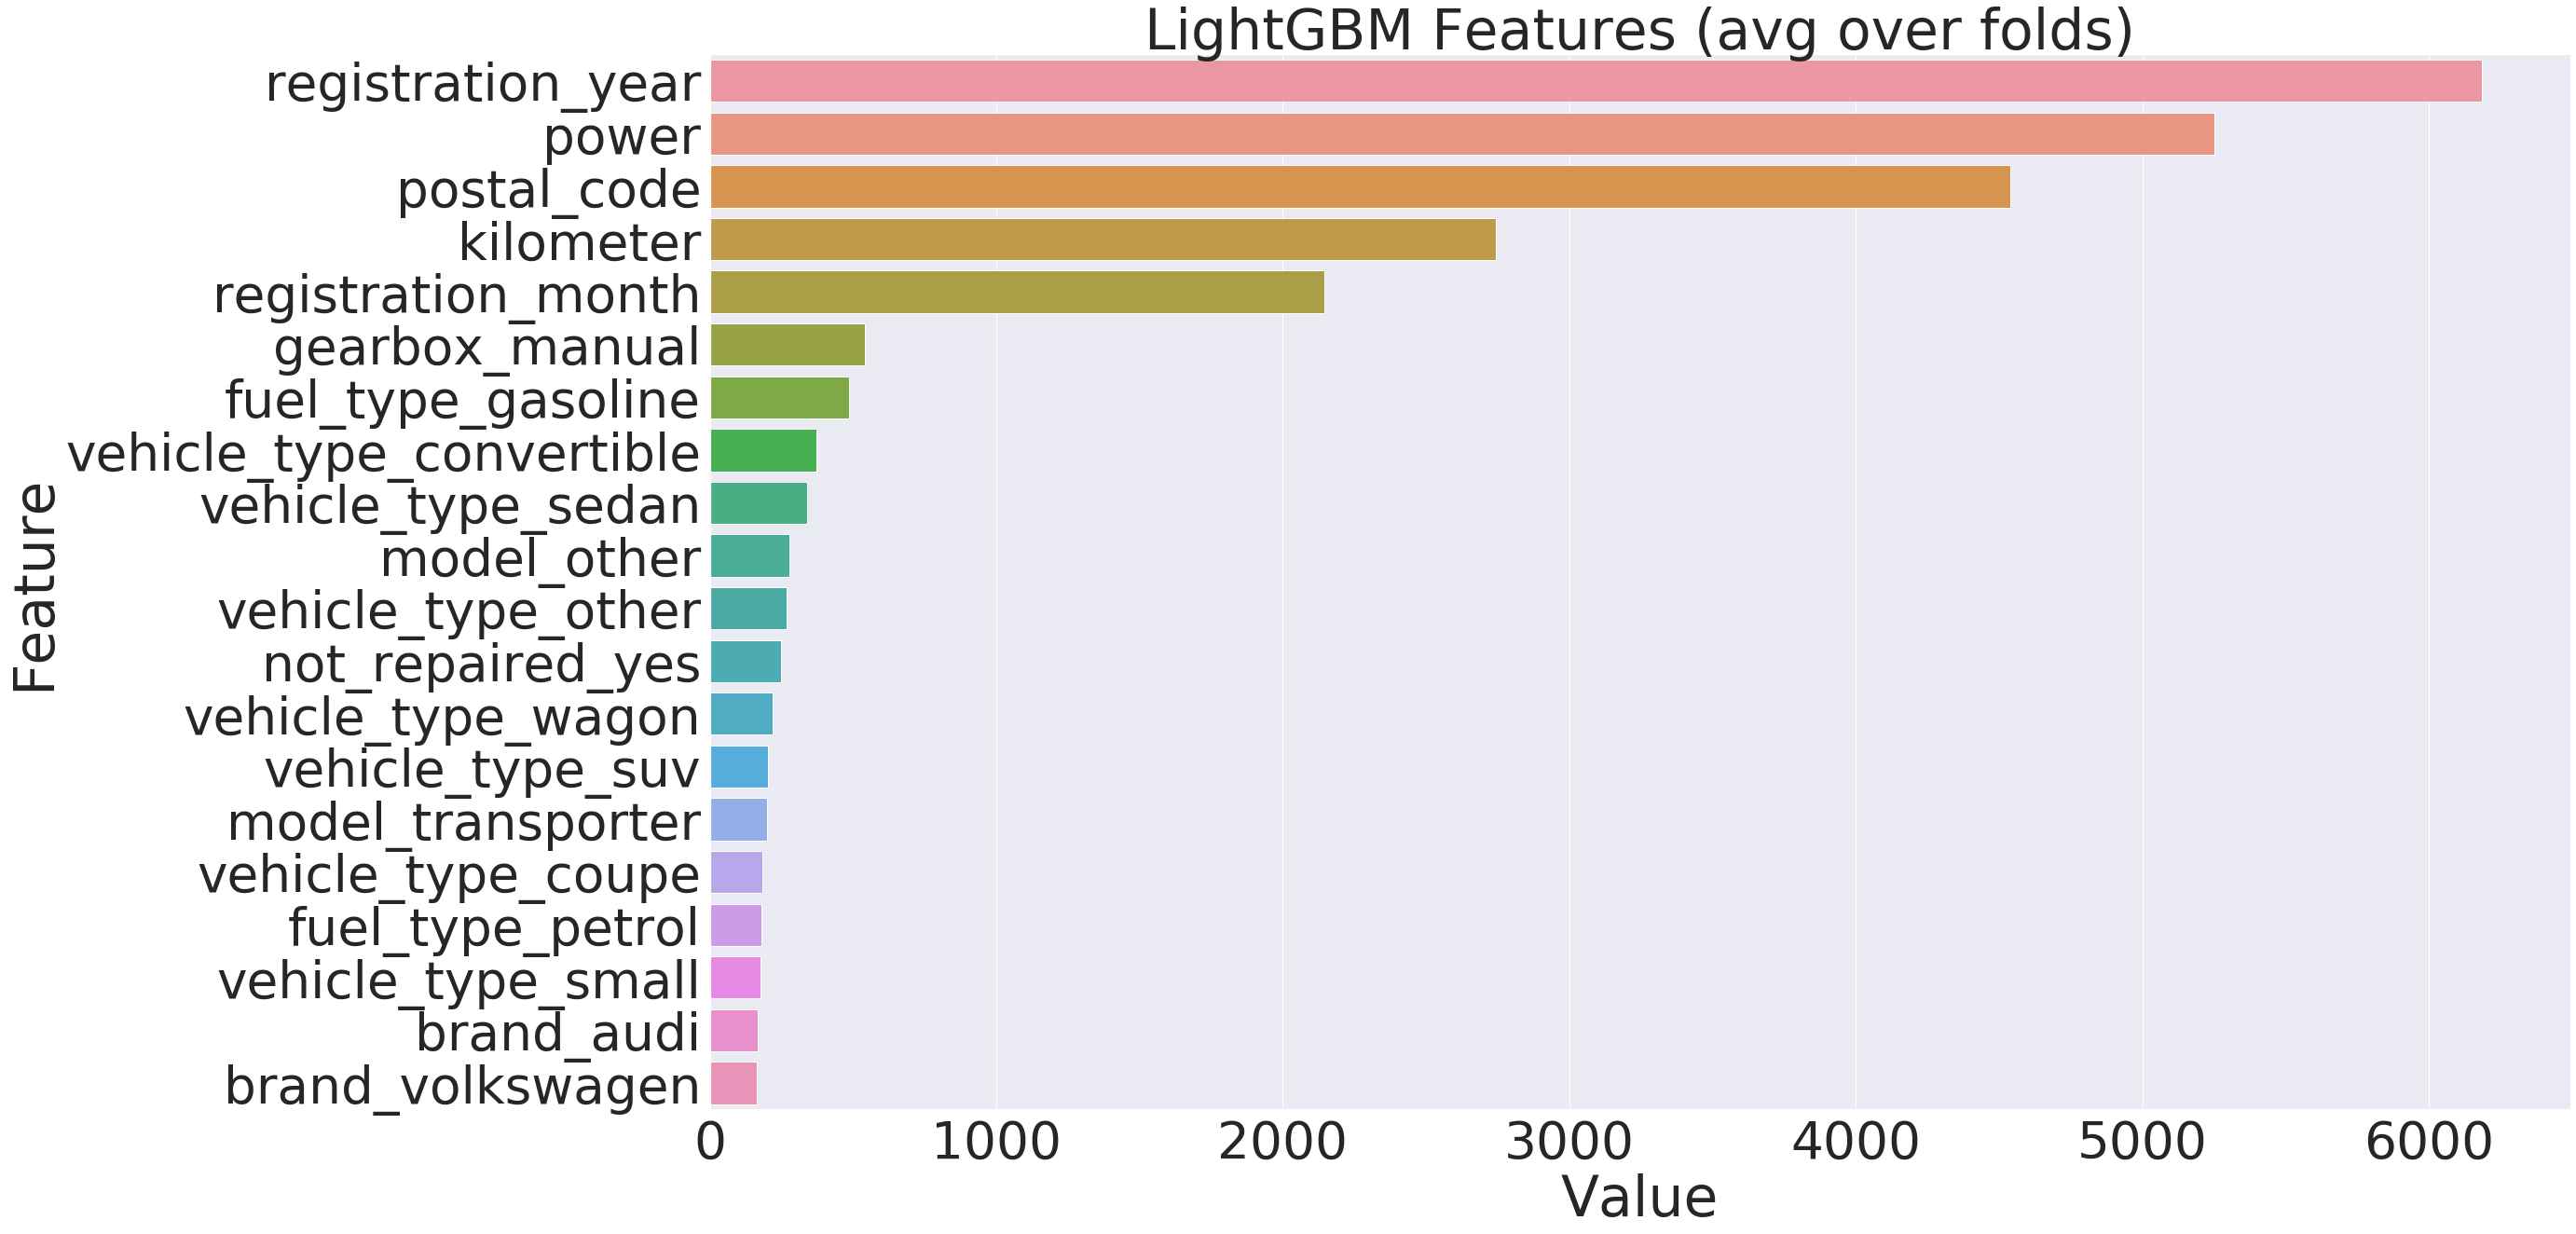

In [88]:
plotImp(gbm, features_train)

**Вывод** RMSE ниже чем при линейной регрессии, время обучения почти в 2 раза дольше.

### CatBoostRegressor

In [89]:
features_train, features_valid, target_train, target_valid = train_test_split(
    df.drop(['price', 'date_crawled', 'date_created', 'last_seen'], axis=1), df.price, test_size=0.2, random_state=12345)

In [ ]:
%%time
1 + 1
cat_features = ['vehicle_type', 'gearbox', 'model',
                'fuel_type', 'brand', 'not_repaired', 'postal_code', 'registration_year']

cbr = CatBoostRegressor(loss_function="RMSE", iterations=200, random_seed = 12345)

cbr.fit(features_train, target_train, cat_features=cat_features, verbose=0)


In [ ]:
predictions_train = cbr.predict(features_train) #предсказания на обучающей выборке
predictions_valid = cbr.predict(features_valid) #предсказания на валидационной выборке
print("RMSE на обучающей выборке: ", round(mean_squared_error(target_train, predictions_train) ** 0.5, 2)) 
print("RMSE на валидационной выборке: ", round(mean_squared_error(target_valid, predictions_valid) ** 0.5, 2))

In [ ]:
sorted_feature_importance = cbr.feature_importances_.argsort()
plt.barh(features_train.columns[sorted_feature_importance], 
        cbr.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")


In [ ]:
explainer = shap.TreeExplainer(cbr)
shap_values = explainer.shap_values(features_valid)
shap.summary_plot(shap_values, features_valid, feature_names = features_train.columns[sorted_feature_importance])

**Вывод** наилучший результат покзаывает модель CatBoostRegressor дольше всего при этом происходит обучение модели.

<div class="alert alert-block alert-success">
<b>Успех:</b> Молодец, что попробовал разные модели!
</div>

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Пожалуйста, реализуй подбор парамтеров хотя бы для одной из моделей. Я бы использовал кросс-валидацию.
</div>

## Анализ моделей

Анализируя модели видим, что наиболее быстрая модель линейной регрессии показало худшее качество. Модель LightGBM оказалась немного медленее, при этом качество оказалось лучше. Самое высокое качество и медленную скорость показывает модель CatBoodtRegressor.

<div class="alert alert-block alert-info">
<b>Совет: </b> Все показатели(время обучения, время предсказания и качество) желательно было собрать в одной таблице. Так было бы проще сравнивать.
</div>

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей